In [1]:
from tqdm import tqdm
import json
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet as wn
from copy import deepcopy
import re
import math
import spacy
from spacy import displacy
import en_core_web_md
import matplotlib as mpl
import matplotlib.cm as cm

2022-05-05 16:23:58.231645: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-05 16:23:58.231676: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
FILTER_SPOILERS = True

In [3]:
book_id = "41865"
# harry potter and the sorcerer's stone = 3
# twilight = 41865
# the expanse = 8855321
# eric = 64218
# guards guards = 64216

In [4]:
def find_book(book_id):
    with open("data/goodreads_books_fantasy_paranormal.json") as f:
        for line in tqdm(f):
            book = json.loads(line)
            if book["book_id"] == book_id:
                return book
    return None

book = find_book(book_id)

63913it [00:05, 12780.77it/s]


In [5]:
title = book["title"].split("(", 1)[0]
series = book["title"].split("(", 1)[1].rstrip("0123456789#), ")
print(title)
print(series)

Twilight 
Twilight


In [6]:
def get_reviews_from_book_id(book_id):
    reviews = []
    with open("data/goodreads_reviews_fantasy_paranormal.json") as f:
        for line in tqdm(f):
            review = json.loads(line)
            if review["book_id"] == book_id:
                reviews.append(review)
    return reviews

reviews = get_reviews_from_book_id(book_id)

3424641it [00:53, 64560.39it/s]


In [7]:
len(reviews)

10535

In [8]:
def filter_spoilerous(reviews):
    return [review for review in reviews if "spoiler" not in review["review_text"]]

if FILTER_SPOILERS:
    reviews = filter_spoilerous(reviews)

In [9]:
len(reviews)

10326

In [10]:
def get_ids():
    ids = set()
    with open("data/goodreads_reviews_fantasy_paranormal.json") as f:
        for line in tqdm(f):
            review = json.loads(line)
            ids.add(review["book_id"])
    return ids

In [11]:
text = " ".join(review["review_text"] for review in reviews)
tokenized = nltk.word_tokenize(text)

In [12]:
lemmatizer = WordNetLemmatizer()
lemmatized = [
    lemmatizer.lemmatize(word, pos.lower()[0] if pos.lower()[0] in "nvars" else "n").lower()
    for word, pos in nltk.pos_tag(tokenized)
]

In [13]:
def frequent_ngrams(words, n):
    stopwords = nltk.corpus.stopwords.words("english")
    from nltk.util import ngrams
    ngrams = ngrams(words, n)
    filtered_ngrams = [
        ngram for ngram in ngrams
        if all(gram.lower() not in stopwords and gram.isalnum() for gram in ngram)
    ]
    return nltk.FreqDist(filtered_ngrams)

def is_subseq(needle, haystack):
    return any(needle == haystack[i:i+len(needle)] for i in range(0, len(haystack)))

def is_subset(needle, haystack):
    return set(needle).issubset(set(haystack))

def frequent_arbitrarygrams(words, min_, max_, count):
    from nltk.util import ngrams
    stopwords = set(nltk.corpus.stopwords.words("english"))
    words = [word.lower() for word in words if word.isalpha()]

    freq_ngrams = []
    for n in tqdm(range(max_, min_ - 1, -1)):
        ngramed = [ngram for ngram in ngrams(words, n) if n > 4 or not any(word in stopwords for word in ngram)]
        fd = nltk.FreqDist(ngramed)
        for ngram, ngram_freq in fd.most_common():
            for common, common_freq in freq_ngrams:
                if is_subset(ngram, common):
                    fd.update({ngram: -ngram_freq})
        freq_ngrams.extend(fd.most_common(count))
    return freq_ngrams

frequent_arbitrarygrams(lemmatized, 2, 6, 3)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58it/s]


[(('read', 'the', 'rest', 'of', 'the', 'series'), 114),
 (('to', 'read', 'the', 'rest', 'of', 'the'), 75),
 (('what', 'all', 'the', 'fuss', 'be', 'about'), 60),
 (('i', 'could', 'put', 'it', 'down'), 148),
 (('fall', 'in', 'love', 'with', 'a'), 87),
 (('the', 'first', 'time', 'i', 'read'), 82),
 (('nothing', 'happen', 'nothing', 'happen'), 28),
 (('happen', 'nothing', 'happen', 'nothing'), 25),
 (('absolutely', 'positive', 'first', 'edward'), 11),
 (('year', 'old', 'girl'), 79),
 (('best', 'book', 'ever'), 60),
 (('young', 'adult', 'book'), 57),
 (('love', 'story'), 635),
 (('stephenie', 'meyer'), 508),
 (('high', 'school'), 454)]

In [14]:
def sentimental_words(lemmatized, total, treshold):
    sia = SentimentIntensityAnalyzer()
    fd = nltk.FreqDist(lemmatized)
    
    result = []
    for val, freq in fd.most_common():
        scores = sia.polarity_scores(val)
        if abs(scores["compound"]) > treshold:
            result.append((val, freq, scores))
        if len(result) >= total:
            break
    return result

sentimental_words(lemmatized, 20, 0.5)

[('love', 6467, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}),
 ('romance', 1354, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}),
 ('great', 1160, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}),
 ('bad', 949, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423}),
 ('best', 788, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}),
 ('hate', 641, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5719}),
 ('fun', 630, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5106}),
 ('kind', 606, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5267}),
 ('perfect', 550, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}),
 ('amazing', 389, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5859}),
 ('beautiful', 382, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5994}),
 ('loved', 358, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5994}),
 ('kill', 280, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.6908}),
 ('stupid', 276, {

In [15]:
nlp = en_core_web_md.load()
nlp.max_length = len(text)

In [16]:
print("chars", len(text))
print("words", len(text.split()))

chars 4675723
words 857461


In [17]:
doc = nlp(text)

In [18]:
ents = [ent for ent in doc.ents if ent.label_ in ["PERSON", "WORK_OF_ART"]]

In [19]:
def no_unsquishables(needle, haystack, unsquishables):
    for h in haystack:
        if h in unsquishables and h not in needle:
            return False
    return True

def is_word_aware_infix(needle, haystack, unsquishables):
    needle = re.split("[^a-zA-Z]+", needle.lower())
    haystack = re.split("[^a-zA-Z]+", haystack.lower())
    for i in range(len(haystack) - len(needle) + 1):
        if needle == haystack[i:i+len(needle)] and no_unsquishables(needle, haystack, unsquishables):
            return True        
    return False

def contained_in(needle_half, haystack, unsquishables):
    result = set()
    for hay in haystack:
        if needle_half != hay and is_word_aware_infix(needle_half, hay, unsquishables):
            result.add(hay)
    return result

def propagate(mapping):
    for from_, to_ in mapping.items():
        current = mapping[from_]
        stack = [from_]
        while current != mapping[to_]:
            stack.append(current)
            current = mapping[to_]
        for item in stack:
            mapping[item] = current
    return mapping

def squish(values, unsquishables=set(), unremapables=set()):
    unprocessed = set(values)

    mapping = {val:val for val in values}
    for val in values:
        if val not in unprocessed:
            continue
        for con in contained_in(val, unprocessed, unsquishables):
            if not any(is_word_aware_infix(con, word, unsquishables) for word in unremapables) or con.lower() == val.lower():
                mapping[con] = val
            unprocessed.remove(con)
        
    return propagate(mapping)

def squish_ents(people, count=20, unremapables=set()):
    fdp = nltk.FreqDist(ent.text for ent in people)
    names = [p[0] for p in fdp.most_common(count)]
    return squish(names, unremapables=unremapables)

names_mapping = squish_ents(ents, unremapables={title, series})

In [20]:
names_mapping

{'Edward': 'Edward',
 'Bella': 'Bella',
 'Twilight': 'Twilight',
 'Meyer': 'Meyer',
 'Stephenie Meyer': 'Meyer',
 'Edward Cullen': 'Edward',
 'Harry Potter': 'Harry Potter',
 'Stephanie Meyer': 'Meyer',
 'Bella Swan': 'Bella',
 'Alice': 'Alice',
 'Cullens': 'Cullens',
 'the Twilight series': 'Twilight',
 'Anne Rice': 'Anne Rice',
 'James': 'James',
 "Stephenie Meyer's": 'Meyer',
 'Meyers': 'Meyers',
 'Charlie': 'Charlie',
 'Cullen': 'Cullen',
 'Dracula': 'Dracula',
 'Romeo': 'Romeo'}

In [21]:
def compute_vocab_sentiment(doc):
    sia = SentimentIntensityAnalyzer()
    for word in doc.vocab:
        scores = sia.polarity_scores(word.text)
        doc.vocab[word.text].sentiment = scores["compound"]

compute_vocab_sentiment(doc)

In [26]:
def get_dependent(token, dependencies, passthroughs=[], deep=False, result=None):
    result = result if result is not None else []
    for child in token.children:
        if child.dep_ in dependencies:
            result.append(child)
        if deep or child.dep_ in passthroughs:
            get_dependent(child, dependencies, passthroughs, deep, result)
    
    return result

def get_what(parent):
    what = []
    if not what:
        what = get_dependent(parent, ["acomp"], ["xcomp"])
    if not what:
        what = get_dependent(parent, ["attr"])
    if not what:
        what = get_dependent(parent, ["pobj"], ["prep"])
    if not what or what[0].pos_ == "PRON":
        return []
    return what


def get_negs(parent, what, old_negs=None):
    negs = []
    if not negs:
        negs = get_dependent(parent, ["neg"])
    if not negs:
        negs = [det for det in get_dependent(what, ["det"]) if det.text.strip().lower() == "no"]
    if not negs:
        return old_negs if old_negs is not None else []
    return negs


def get_mods(what, start=None):
    preps = [what.head] if what.head.dep_ == "prep" and what.head.head == start else []
    mods = get_dependent(
        what,
        ["amod", "compound", "advmod", "nummod", "npadvmod", "pobj", "prep", "poss", "case"],
        ["amod", "compound", "advmod", "nummod", "npadvmod", "pobj", "prep", "poss"],
    )
    mods = [mod for mod in mods if (start is None or mod.i > start.i) and mod.pos_ != "SCONJ"]
    return preps + mods


def get_adj_mods(what, start=None):
    mods = get_mods(what, start)
    return [mod for mod in mods if mod.pos_ in ["ADJ", "NOUN"] and mod.i < what.i]


def get_description_from_mods(token):
    return [[mod] for mod in get_adj_mods(token)]


def get_description_from_aux(token, aux):
    whats = get_what(aux)
    if not whats:
        return []

    result = []
    negs = get_negs(aux, whats[0])
    while whats:
        if len(whats) > 1:
            result.append(whats)
            break
        
        what = whats[0]
        mods = get_mods(what, aux)
        desc = sorted(negs + mods + [what], key=lambda tok: tok.i)
        result.append(desc)
    
        whats = get_dependent(what, ["conj"])
    
    return result

def get_descriptions(token):
    descs = get_description_from_mods(token)
    if descs:
        return descs

    while token.dep_ == "conj":
        token = token.head

    if token.dep_ == "nsubj" and token.head.pos_ == "AUX":
        return get_description_from_aux(token, token.head)
    return []

def add_descriptions(i, word, descs, key, result, verbose):
    if not descs:
        return

    parent = word.head if word.head.pos_ == "AUX" else None
    if (verbose == 1 and not descs) or (verbose == 2 and descs) or verbose >= 3:
        print(i, word)
    if verbose >= 2:
        for desc in descs:
            print(" "*len(str(i)), word, parent if parent is not None else "is", *desc)
    if (verbose == 1 and not descs) or (verbose == 2 and descs) or verbose >= 3:
        print(word.sent)
        print()

    old_descs = result.get(key, [])
    old_descs.extend(descs)
    result[key] = old_descs

def get_character_descriptions(people, verbose=0):
    result = {}
    for i, person in enumerate(people):
        if person.text not in names_mapping:
            continue
        word = person.root
        descs = get_descriptions(word)
        add_descriptions(i, word, descs, names_mapping[person.text], result, verbose)
    
    return result

def get_aspect_descriptions(doc, aspects, verbose=0):
    result = {}
    for i, word in enumerate(doc):
        if word.text not in aspects:
            continue
        descs = get_descriptions(word)
        add_descriptions(i, word, descs, word.text, result, verbose)

    return result

character_descriptions = get_character_descriptions(ents)
aspect_descriptions = get_aspect_descriptions(doc, ["book", "story", "writing", "characters", "pacing"])

Edward 866 

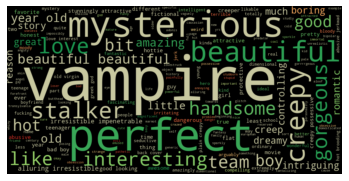

literal manifestation of kid 's school crush without vampiric bits
most blatant example of author male fantasy insertion in story
arguably less vicious than evil count of transylvania
new long haired cover boy for future romance books
perfect literary romantic lead in age of education
less of creepy bipolar manic depressive twit
posing as high school student in cloudy town
creepy 100 something year old virgin vampire
not as compelling character as harry potter

Bella 325 

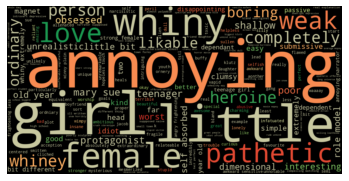

very poorly sculpted main character with little characterization
stereotypical stupid victim character from horror movie
fairly realistic as selfish self absorbed teenage girl
too obsessed with edward with real explanation other
by far one of worst heroines in literary history
sullen self absorbed teenager with serious crush
one acception to edward 's mind reading skills
mary sue of extremely annoying clumsy kind

Meyer 185 

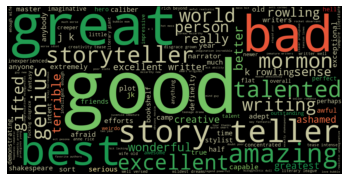

intense story teller better than any of anne rice 's efforts
prodigious young woman with amazing talent for
no literary giant by anybody 's imagination
good author with great sense of creativity
little too concentrated on teenage drama
in same literary league as j.k. rowling
one of most juvenile immature writers

Twilight 121 

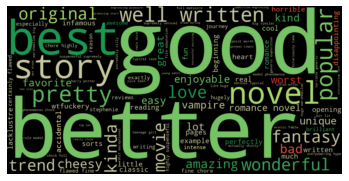

great journey through united worlds of fantasy
my kind of book especially from reviews about
400 pages of terrible generic exposition
typical case of overpowering hype
just stephenie meyer 's wet dream
very beginning of bit lit trend

Harry Potter 34 

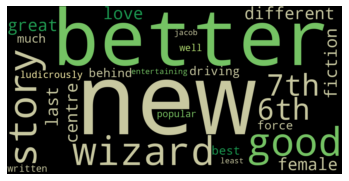

driving force behind me
better than twilight
ludicrously popular
at least good story
very well written

Cullens 30 

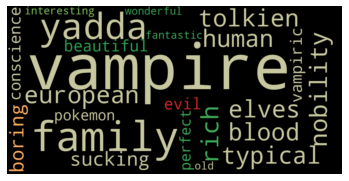

not their typical human blood sucking vampires
perfect yadda yadda yadda
vampires with conscience
interesting characters

Alice 25 

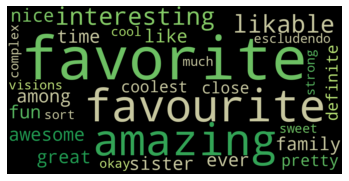

one of my favorite characters ever
very interesting with her visions
my favourite among cullen family
most likable characters in book

Dracula 10 

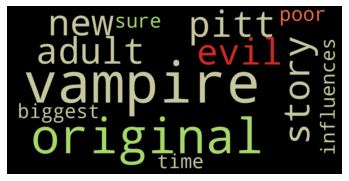

one of biggest influences
story of evil vampire
only vampire book

book 3840 

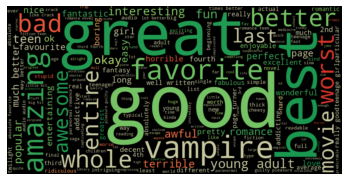

perfect vampire drama for young fantasy reader with mushy clay heart
she's looking longingly at him looking longingly at her yawn fest
only slightly better than badly photographed movie version
like written equivalent of lifetime movie in slow motion
poorly timed mish mash of highly romanticized fantasies
interesting twist to typical high school love stories
full of references to splendor of olympic peninsula
really popular with young adult crowd at library
harlequin romance novel for chaste younger crowd
awesome love story between two different beings
grotesque festering wound on face of literature

story 2065 

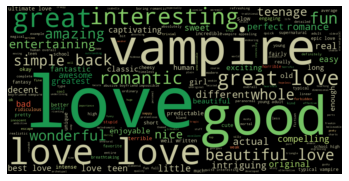

indelible touchstone for current generation of youthful readers
about likeable teenage girl short for isabella
do for one u love with regert for result now
different than your typical vampire story
interestingly developed with characters
more endearing than story about vampire
different from traditional vampire book
about ordinary average looking girl
like steady lake throughout book
story about young teenage girl
definitely compelling enough

characters 895 

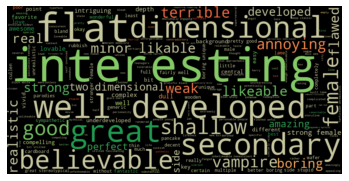

cute teenagy with angst of daily life in small town
well developed throughout course of multiple books
two dimensional parodies of teenagers
nonexistant in second half of novel
less believable than in city series
not my favorite part about story
wooden parodies of other trope
interesting in their own ways
all so individually appealing

writing 688 

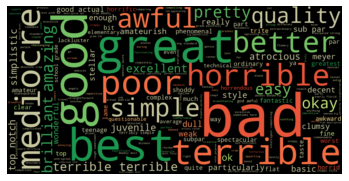

comprehensively amateurish on most other regards
only couple of notches above mediocre
occasionally contrivedly pretentious
not that different than choppy style
more unoriginal than average writer
simple comparing to many books
worse offense than bad writing
far better than most authors '
style very boring declarative

pacing 18 

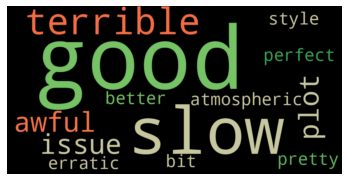

so perfect for
not my style
issue-- slow
bit erratic



In [27]:
def word_to_color(word, *args, **kwargs):
    sentiment = doc.vocab[word].sentiment

    norm = mpl.colors.Normalize(vmin=-0.8, vmax=0.8)
    cmap = cm.RdYlGn

    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    color = tuple(map(lambda v: int(255*v), m.to_rgba(sentiment)[:3]))
    return color if color != (254, 254, 189) else (200, 200, 160)

def print_descriptions(descs, min_descs=15, extra_stopwords=set()):
    forbidden = set(nltk.corpus.stopwords.words("english")) | extra_stopwords | descs.keys()
    for key, descs in sorted(descs.items(), key=lambda pair: len(pair[1]), reverse=True):
        descs = [" ".join(word.text if word.text != "n't" else "not" for word in desc).lower() for desc in descs]
        if len(descs) < min_descs:
            continue

        print(key, len(descs), end=" ")

        from wordcloud import WordCloud
        import matplotlib.pyplot as plt
    
        wordcloud = WordCloud(
            width=1200,
            height=600,
            stopwords=forbidden,
            collocation_threshold=10,
            color_func=word_to_color
        ).generate(" ".join(descs))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        
        print(*sorted(set(descs), key=len, reverse=True)[:int(math.log(len(descs), 2))], sep="\n")
        print()

extra_stopwords = {
    "character", "characters", "writer", "author", "one", "first", "second", "last"
    "whole", "book", "books", "series", "man", "woman", "place", "next",
    "able", "read", "reader", "main", "many"
}

print_descriptions(character_descriptions, min_descs=10, extra_stopwords=extra_stopwords)
print_descriptions(aspect_descriptions, min_descs=10, extra_stopwords=extra_stopwords)

In [39]:
def get_descriptions_from_object(verb):
    whats = [what for what in get_dependent(verb, ["dobj"]) if what.pos_ != "PRON" and what.text != verb.text]
    descs = []
    for what in whats:
        descs += [
            sorted(get_negs(verb, what) + desc + [what], key=lambda word: word.i)
            for desc in get_descriptions(what)
        ]
    return descs

def get_described_entity_from_mod(mod):
    desc = []
    negs = []
    current = mod
    while current.dep_ in ["amod", "compound", "advmod", "attr"]:
        if current.head.lemma_.lower() != mod.lemma_.lower() and current.head.pos_ not in ["AUX"]:
            negs.extend(get_dependent(current, ["neg"]))
            desc.append(current.head)
        current = current.head
    negs.extend(get_dependent(current, ["neg"]))
    if not desc:
        return []
    return [sorted(negs + desc, key=lambda word:word.i)]

def get_described_entity_from_subject(mod):
    if mod.dep_ == "nsubj":
        return []

    parent = mod.head
    while parent.text.strip() and parent.dep_ in ["amod", "compound", "advmod"]:
        parent = parent.head
    
    if parent.pos_ == "AUX":
        subjs = get_dependent(parent, ["nsubj"])
        if len(subjs) == 1 and subjs[0].pos_ not in ("PROP", "PRON", "PUNCT", "SCONJ"):
            mods = get_mods(subjs[0])
            mods.append(subjs[0])
            return [sorted(mods, key=lambda word: word.i)]
    return []

def get_sentimental_descriptions(doc, sent_threshold, verbose=0):
    result = {}
    for i, word in enumerate(doc):

        if abs(word.sentiment) < sent_threshold:
            continue

        key = word.text.lower()
        descs = []
        if word.pos_.startswith("N"):
            descs.extend(get_descriptions(word))

        if word.pos_.startswith("V"):
            descs.extend(get_descriptions_from_object(word))
            
        descs.extend(get_described_entity_from_mod(word))
        descs.extend(get_described_entity_from_subject(word))
        
        add_descriptions(i, word, descs, key, result, verbose)

    return result

sentimental_descriptions = get_sentimental_descriptions(doc, 0.6)

love 1847 

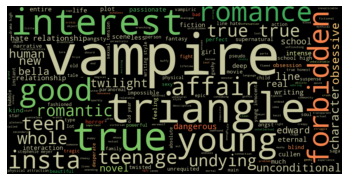

even more unrealistic as disney movie
supporting cast of characters
one of central themes of book
not love deep down inside me
stephenie meyer 's twilight
my experience with twilight
kind of instant attraction
relationship between bella
main atraction from book
supernatrual phenomenon

great 986 

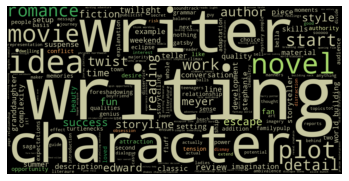

meyer 's sense of storytelling complexity
edward obsession for him
meyers balance of good
writing in twilight
quality of writing
actual literature
idea entertaining
storyline in book
idea behind story

best 661 

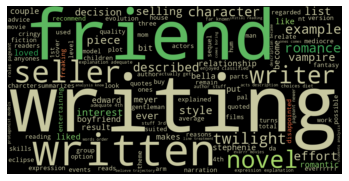

romantic relationship between edward
stephenie meyer 's writing style
first book in twilight series
-edward 's reasons for
ever!!!!!!!!!!!!!!!!i
her skills as writer
trajectory of bella
are selling writers
meyer 's characters

worst 203 

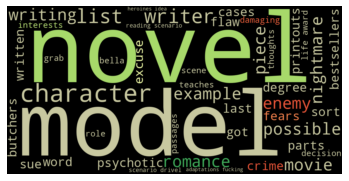

reading scenario
possible model
fucking novel
possible word
written book
adaptations
bestsellers

awesome 138 

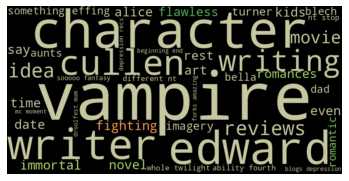

whole twilight series
flawless character
even my immortal
rest of cullens
edward cullen
series(effing
amazing story

abusive 105 

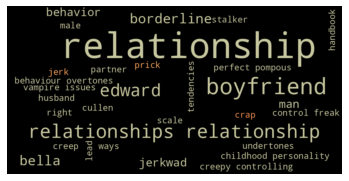

was not relationship
edward relationship
bella relationship
relationship scale
edward cullen
control freak

perfectly 101 

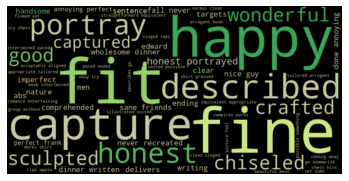

equivalent appropriate
something destructive
entertaining read
sculpted vampires
wholesome dinner
wonderful edward

gorgeous 75 

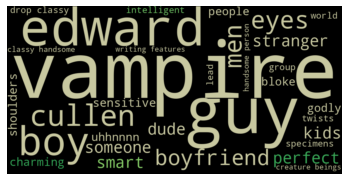

drop classy handsome
intelligent cullen
perfect vampire
sensitive one
are vampires
specimens

evil 59 

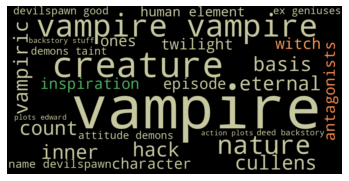

basis of his vampiric nature
very inspiration of twilight
human element of vampires
eternal as vampires
for antagonists

greatest 54 

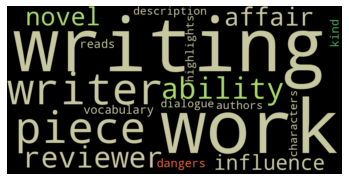

your vocabulary
not influence
not reviewer
description
characters

dead 48 

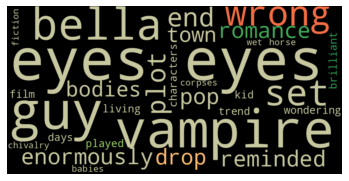

enormously reminded of pop
vampire fiction
characters
wondering
brilliant

abuse 29 

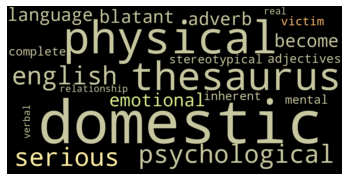

english language
psychological
stereotypical
relationship

hated 28 

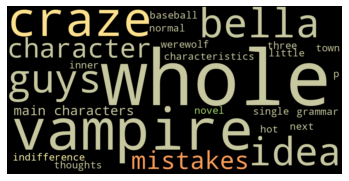

vampire characteristics
single character
grammar mistakes
main characters

violence 25 

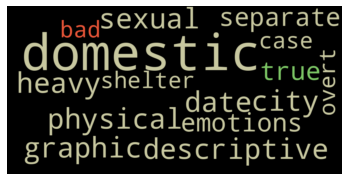

separate emotions-
descriptive
physical
domestic

masterpiece 24 

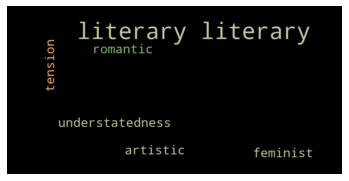

very understatedness of romantic tension
feminist
literary
artistic

hell 15 

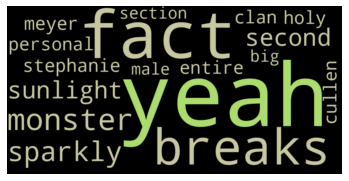

all sparkly in sunlight
second stephanie meyer
entire cullen clan

amor 13 

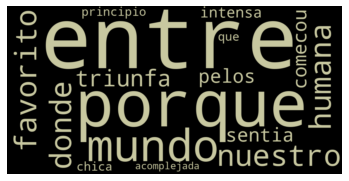

chica acomplejada
nuestro favorito
pelos comecou

horrific 13 

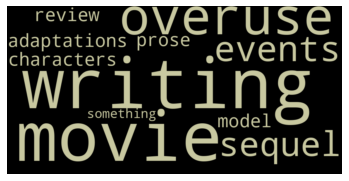

is something
adaptations
characters

kill 12 

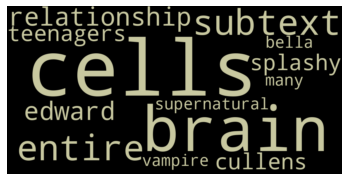

subtext of entire relationship between edward
supernatural being
not brain cells

villains 10 

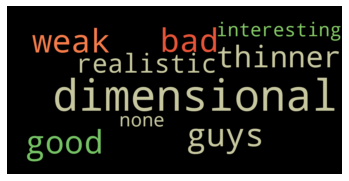

not any thinner
none of them
interesting

killer 10 

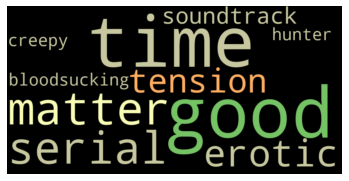

erotic tension
bloodsucking
soundtrack

brilliantly 10 

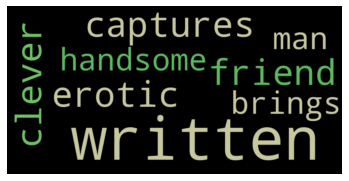

clever friend
handsome man
erotic thing



In [40]:
forbidden_sentimentals = {
    "thing", "things", "one", "way", "part", "deal", "job", "first",
    "book", "books", "serie", "series", "story", "stories", "read",
    "literature"
}
print_descriptions(sentimental_descriptions, min_descs=10, extra_stopwords=forbidden_sentimentals)

In [41]:
print("characters", sum(len(foo[1]) for foo in character_descriptions.items()))
print("aspects", sum(len(foo[1]) for foo in aspect_descriptions.items()))
print("sentimental", sum(len(foo[1]) for foo in sentimental_descriptions.items()))
print("total", len(list(doc.sents)))
print()

sum_ = sum(len(foo[1]) for foo in character_descriptions.items()) \
+ sum(len(foo[1]) for foo in aspect_descriptions.items()) \
+ sum(len(foo[1]) for foo in sentimental_descriptions.items())

total = len(list(doc.sents))

print("percentage", f"{sum_ / total * 100:.2f} %")

characters 1634
aspects 7506
sentimental 4633
total 62167

percentage 22.15 %
